In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.stats import multivariate_normal
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [2]:
def estimate_gaussian(X):
    """Return estimated multivariate normal random variable."""
    mu = X.mean(axis=0)
    sigma = np.cov(X.T)
    return multivariate_normal(mean=mu, cov=sigma)

def predict_anomaly(gaussian, X, eps):
    """Return a binary array where samples with probability below given epsilon
    are labeled as anomalies."""
    p = gaussian.pdf(X)
    return (p < eps).astype(int)

def select_threshold(gaussian, X, y):
    """Return epsilon that gives the highest F1 score on the given data set."""
    p = gaussian.pdf(X)
    epsilons = np.linspace(p.min(), p.max(), 1000)
    f1s = np.array([f1_score(y, predict_anomaly(gaussian, X, eps))
                    for eps in epsilons])
    best_f1 = f1s.max()
    best_eps = epsilons[f1s.argmax()]
    return best_eps, best_f1

In [3]:
# Load data
data = loadmat('./data/ex8data2.mat')
X_train = data['X'][:, :2]
X = data['Xval'][:, :2]
y = data['yval'].astype(int).flatten()

# Split into dev and test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=7)
dev_idx, test_idx = next(sss.split(X, y))
X_dev, y_dev = X[dev_idx], y[dev_idx]
X_test, y_test = X[test_idx], y[test_idx]

# Estimate Gaussian
gaussian = estimate_gaussian(X_train)

# Choose epsilon using dev set
eps, f1 = select_threshold(gaussian, X_dev, y_dev)

# Predict on test set
y_pred = (gaussian.pdf(X_test) < eps).astype(int)
print('Dev set F1 score: {:.2f}'.format(f1))
print('Test set F1 score: {:.2f}'.format(f1_score(y_test, y_pred)))

/Users/Admin/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Dev set F1 score: 0.80
Test set F1 score: 0.50


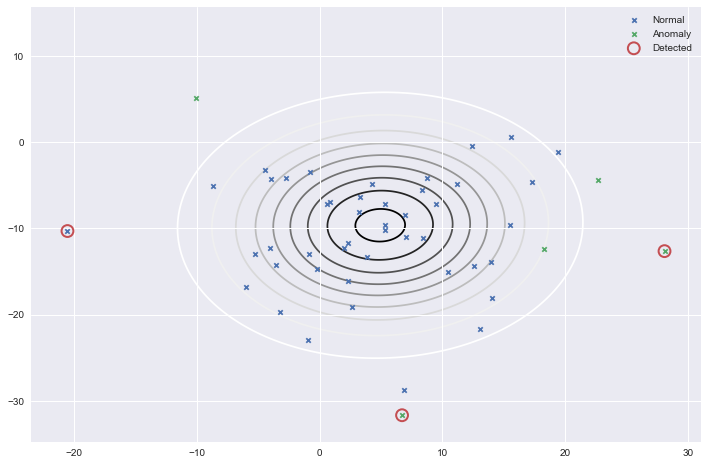

In [4]:
# Generate grid points
n_grids = 1000
u = np.linspace(X[:, 0].min(), X[:, 0].max(), n_grids)
v = np.linspace(X[:, 1].min(), X[:, 1].max(), n_grids)
grid_X, grid_Y = np.meshgrid(u, v)
Z = gaussian.pdf(np.concatenate([grid_X.reshape(-1, 1), grid_Y.reshape(-1, 1)],
                                axis=1)).reshape((n_grids, n_grids))

# Plot
plt.figure(figsize=(12, 8))
plt.contour(grid_X, grid_Y, Z, 10, zorder=0)
plt.scatter(X_test[~y_test.astype(bool), 0], X_test[~y_test.astype(bool), 1],
            s=20, marker='x', label='Normal')
plt.scatter(X_test[y_test.astype(bool), 0], X_test[y_test.astype(bool), 1],
            s=20, marker='x', label='Anomaly')
plt.scatter(X_test[y_pred.astype(bool), 0], X_test[y_pred.astype(bool), 1],
            s=140, linewidth=2, facecolor='none', edgecolor='C2', label='Detected')
plt.legend()
plt.show()